This notebook is chaos - it is a messy lab notebook where I was learning how to download MOM6 data, then use xarray to select, mask, group and calculate means for the variables. I would not recommend running it, use the next one instead.

## Filter and aggregate data

Helpful links:
* [Accessing CEFI data with Python](https://noaa-cefi-portal.github.io/cefi-cookbook/content/data_access/access_cefi/python_get_cefi.html)
* [Data Availability Accounting](https://docs.google.com/document/d/1P8D0kH2xn4NYBc0ib3rYfSO0KAiyDNQ_kZgG4Qub7qY/edit?tab=t.0#heading=h.b43v7gxhe7oj)
* [Environmental Predictors](https://docs.google.com/spreadsheets/d/1tPmxlgaP8pwgAjt4m7omwbhQGHKxIfKaV-YM82VCUFM/edit?gid=1829421175#gid=1829421175)
* [Copy of Megan's Environmental Predictors](https://docs.google.com/spreadsheets/d/1MzrQR4iNgN_8TZ5Mc2ei2darMIsqhV9NZvTCkRt1QFE/edit?gid=643914782#gid=643914782)
* [ROMS request for Yellowtail](https://docs.google.com/spreadsheets/d/1uxJAqG5MHReSdr1pe_ASxqpCeAhqvuxYKr-qh2EFXPg/edit?gid=1062630878#gid=1062630878)
* [Groundfish Indices Variables from MOM6](https://docs.google.com/spreadsheets/d/1Z_bS9K7KEmnRCwz5ZAaQ49i6xC9JOaIeVcOjuQF59JI/edit?gid=0#gid=0)
* [Owen's code to pull GLORYS data](https://github.com/owenrliu/cefi-hake/blob/b5eeef46349673428788c42dcb2f0360f1686e3b/code/01_download_GLORYS.R)

I used the Data Query Generator at the [CEFI Data Portal](https://psl.noaa.gov/cefi_portal/#data_access) to generate a URL.
* Region: NEP
* Subregion: full domain
* Experiment Type: hindcast
* Output Frequency: monthly regrid
* Release: r20250509
* Data Category: ocean_monthly_z
* Variable: thetao (Sea Water Potential Temperature)

I'm using a newer release than notebook 1: `r20250509`. This extends the end date of the hindcast from December 2019 to December 2024.

The data category and variable changed for different variables, the rest was the same.

I tried following the CEFI cookbook for python locally and in cloud, but neither worked to download the temperature data. It could have been user error on my end, but the cookbooks unfortunately only cover pulling one time slice, not how to iteratively pull years of data, which is what I actually needed to do.
Running locally, the error I hit was `NetCDF: DAP failure`. I don't have the cloud related errors copy/pasted.

I ended up downloading netCDF files with wget commands, which were genrated on the data portal. Pasting what I ran:

* `wget -O MLD_003.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc https://psl.noaa.gov/thredds/fileServer/Projects/CEFI/regional_mom6/cefi_portal/northeast_pacific/full_domain/hindcast/monthly/regrid/r20250509/MLD_003.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc`
* `wget -O thetao.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc https://psl.noaa.gov/thredds/fileServer/Projects/CEFI/regional_mom6/cefi_portal/northeast_pacific/full_domain/hindcast/monthly/regrid/r20250509/thetao.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc`
* `wget -O uo_rotate.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc https://psl.noaa.gov/thredds/fileServer/Projects/CEFI/regional_mom6/cefi_portal/northeast_pacific/full_domain/hindcast/monthly/regrid/r20250509/uo_rotate.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc`
* `wget -O vo_rotate.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc https://psl.noaa.gov/thredds/fileServer/Projects/CEFI/regional_mom6/cefi_portal/northeast_pacific/full_domain/hindcast/monthly/regrid/r20250509/vo_rotate.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc`

**Filtering**:

Based on the data availability accounting document:

* *Parturition*
Jan - Apr
Water column
Bottom depths 0 - 180 m
40° - 48° N
* *Larvae*
Feb - Mar
Water column
Bottom depths 0 - 90 m
40° - 48° N
* *Pelagic juvenile*
Apr - Aug
Water column
Bottom depths 30 - 130 m
40° - 48° N

Based on the yellowtail appendix:

* Time frame: 1993-01-01 to most recent available (2024-12-31)
1) Subsetted data by depth
3) Subsetted data by the relevant time periods
4) Calculated the annual average for 1993-2024 for that
potential predictor

In [ ]:
import xarray as xr
import numpy as np
import time

In [ ]:
# open mixed layer depth dataset
mld = xr.open_dataset("../../../MLD_003.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc")
mld

In [ ]:
# open datasets from Mike, though I don't think I need these yet...
dist_to_coast = xr.open_dataset("../recruitment_model_scripts_matlab/mom6_regrid_dist2coast_CCS.nc") # has lon, lat, dist
coast_angle = xr.open_dataset("../recruitment_model_scripts_matlab/mom6_regrid_coastangle_CCS.nc") # has lat, coast_angle

Playing around with xarray...

In [ ]:
# how to slice by month and latitude
mld.sel(time = slice('1993-01', '1993-04'), lat = slice(40, 48)).load()

In [ ]:
# how to access the data as a numpy array rather than an xarray Dataset
mld.sel(time = '1993-01', lat = slice(40, 48)).load().MLD_003.data

In [ ]:
# how many nans are in here anyway?
np.isnan(mld.sel(time = '1993-01', lat = slice(40, 48))).sum().MLD_003.data

In [ ]:
# out of how many records total? (I'm not sure if this is the best way to access the data btw... seems clunky)
np.isnan(mld.sel(time = '1993-01', lat = slice(40, 48))).MLD_003.data.size

In [ ]:
# how to calculate the mean, ignoring nans?
np.mean(mld.sel(time = '1993-01', lat = slice(40, 48)))

In [ ]:
# how to slice by months across years, and latitudes (i.e. Jan - Apr for all years)
mld.sel(time = mld.time.dt.month <= 4, lat = slice(40, 48))

In [ ]:
# how to slice by months across years, and latitudes (i.e. Feb to Mar for all years)
mld.sel(time = mld.time.dt.month.isin([2,3]), lat = slice(40, 48))

In [ ]:
# how can I filter time and latitude, then group by year and get an annual mean?

# start timer
start_time = time.time()

# the step I care about
mld_fm = mld.sel(time = mld.time.dt.month.isin([2,3]), lat = slice(40, 48))
mld_fm_yearly_mean = mld_fm.groupby('time.year').mean(dim = ['lat', 'lon', 'time'])

# end timer
end_time = time.time()
print(f'Runtime: {round((end_time - start_time) / 60, 2)} minutes')

# look at thing I care about
mld_fm_yearly_mean

In [ ]:
# how to convert that result to a pandas dataframe and write to CSV?
df = mld_fm_yearly_mean.to_dataframe()
df.to_csv('mld.csv') # this is not correct data yet, I haven't filtered on bathymetry yet

In [ ]:
# how to do the same thing, but over depth? now try with the temperature data. (expecting potential issues with the size of that)
# this is ugly, gotta clean up this folder structure!
temp = xr.open_dataset("../../../thetao.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc")

In [ ]:
# filter for 
#Larvae Feb - Mar Water column Bottom depths 0 - 90 m 40° - 48° N
temp_fm = temp.sel(time = temp.time.dt.month.isin([2, 3]), lat = slice(40, 48))
temp_fm

In [ ]:
# calculate the average across time, depth, lon and lat

# start timer
start_time = time.time()

# calculate thing I care about
temp_fm_yearly_mean = temp_fm.groupby('time.year').mean(dim = ['time', 'z_l', 'lon', 'lat'])

# end timer
end_time = time.time()
print(f'Runtime: {round((end_time - start_time) / 60, 2)} minutes')

# look at thing I care about
temp_fm_yearly_mean

I need bathymetry data, so I'm going to now download the raw rather than regridded MLD and the static file, which has bathymetry I can join to.

Ok irritating, the static file won't generate a query automatically. Darren told me that, and I forgot. But he also shared a link: https://psl.noaa.gov/thredds/catalog/Projects/CEFI/regional_mom6/cefi_portal/northeast_pacific/full_domain/hindcast/monthly/raw/r20250509/catalog.html?dataset=Projects/CEFI/regional_mom6/cefi_portal/northeast_pacific/full_domain/hindcast/monthly/raw/r20250509/ocean_static.nc

Here's the generated query for raw MLD:

`wget -O MLD_003.nep.full.hcast.monthly.raw.r20250509.199301-202412.nc https://psl.noaa.gov/thredds/fileServer/Projects/CEFI/regional_mom6/cefi_portal/northeast_pacific/full_domain/hindcast/monthly/raw/r20250509/MLD_003.nep.full.hcast.monthly.raw.r20250509.199301-202412.nc`

Copying that format for the static file:

`wget -O ocean_static.nc https://psl.noaa.gov/thredds/fileServer/Projects/CEFI/regional_mom6/cefi_portal/northeast_pacific/full_domain/hindcast/monthly/raw/r20250509/ocean_static.nc`

Sweet, that worked.

In [ ]:
# open raw mixed layer depth dataset
mld_raw = xr.open_dataset("../../Data/MOM6/MLD_003.nep.full.hcast.monthly.raw.r20250509.199301-202412.nc")
mld_raw

In [ ]:
# open static dataset
static_raw = xr.open_dataset("../../Data/MOM6/ocean_static.nc")
static_raw

In [ ]:
# make geolat and geolon into coordinates within static dataset
static_raw = static_raw.set_coords(['geolon', 'geolat'])
static_raw

In [ ]:
# merge datasets

# start timer
start_time = time.time()
# merge
ds_raw = xr.merge([static_raw, mld_raw])
# end timer
end_time = time.time()
print(f'Runtime: {round((end_time - start_time) / 60, 2)} minutes')

ds_raw

In [ ]:
ds_raw.isel(time = 0).deptho.plot(x = 'xh', y = 'yh')

Things that errored:

* Try to visualize bathymetry on lat/long: `ds_raw.isel(time = 0).deptho.plot(x = 'geolat', y = 'geolon')` --> `ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values`
* Try to slice on lat: `ds_raw.sel(geolat = slice(40, 45))` --> `KeyError: "no index found for coordinate 'geolat'"`
* Try mask on lat/long: `mask_180m = ds_raw.isel(time = 0).where(ds_raw.deptho <= 180)
` --> That's based on [GeoHackWeek masking tutorial](https://geohackweek.github.io/nDarrays/09-masking/), but didn't follow the syntax exactly. Not sure if that caused the error, but crashed the kernel 2x.

I got a link to the regridded depth file from Chia-Wei, here's the [link](https://psl.noaa.gov/thredds/catalog/Projects/CEFI/regional_mom6/cefi_derivative/northeast_pacific/full_domain/hindcast/monthly/regrid/r20250509/static/catalog.html) for NEP. Downloading from there to avoid needing to mask on latitude in addition to depth.

To download:
* `wget -O ocean_static.deptho.nc https://psl.noaa.gov/thredds/fileServer/Projects/CEFI/regional_mom6/cefi_derivative/northeast_pacific/full_domain/hindcast/monthly/regrid/r20250509/static/ocean_static.deptho.nc`

---

Fresh start June 10...

* load datasets
* merge datasets
* select months and latitudes
* make mask based on depths
* calculate average

Parturition Jan - Apr Water column Bottom depths 0 - 180 m 40° - 48° N

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import time

In [2]:
# assign months, latitudes, and depths to filter
# all are integers, depths are in meters
# filters are inclusive (closed interval), e.g. depth 0-180 
#   will include depths 0 and 180 in addition to every depth between
min_mon = 1
max_mon = 4
min_lat = 40
max_lat = 48
min_dep = 0
max_dep = 180

In [3]:
# create list with months
mon_list = [x for x in range(min_mon, max_mon+1)]
mon_list

[1, 2, 3, 4]

In [4]:
# create string with variable name
var_name = "MLD_003"

In [15]:
# create string for life stage
suffix = "asdf"

In [5]:
# read in depth and MLD
ds_mld = xr.open_dataset("../../Data/MOM6/MLD_003.nep.full.hcast.monthly.regrid.r20250509.199301-202412.nc")
ds_depth = xr.open_dataset("../../Data/MOM6/ocean_static.deptho.nc")

In [6]:
ds_mld

<xarray.Dataset> Size: 427MB
Dimensions:  (time: 384, lon: 341, lat: 815)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2024-12-16T12:...
  * lon      (lon) float64 3kB 156.9 157.2 157.5 157.8 ... 254.4 254.7 255.0
  * lat      (lat) float64 7kB 10.81 10.89 10.98 11.07 ... 80.55 80.63 80.72
Data variables:
    MLD_003  (time, lat, lon) float32 427MB ...
Attributes: (12/27)
    NumFilesInSet:          1
    title:                  NEP10k_COBALT_92-93_spinup_new_relax_ts
    associated_files:       areacello: 19930101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     areacello
    ...                     ...
    cefi_init_date:         N/A
    cefi_ensemble_info:     N/A
    cefi_forcing:           N/A
    cefi_data_doi:          10.5281/zenodo.13936240
    cefi_paper_doi:         10.5194/gmd-2024-195
    cefi_aux:               Postprocessed Data : regrid to regular grid

In [35]:
# check # and % non-NA data
print(f'{np.isfinite(ds_mld.MLD_003.data).sum()} records')
print(f'{np.isfinite(ds_mld.MLD_003.data).sum() / ds_mld.MLD_003.size * 100:.{2}f}% records')

38069760 records
35.67% records


In [7]:
ds_depth

<xarray.Dataset> Size: 1MB
Dimensions:  (lon: 341, lat: 815)
Coordinates:
  * lon      (lon) float64 3kB 156.9 157.2 157.5 157.8 ... 254.4 254.7 255.0
  * lat      (lat) float64 7kB 10.81 10.89 10.98 11.07 ... 80.55 80.63 80.72
Data variables:
    deptho   (lat, lon) float32 1MB ...
Attributes:
    external_variables:  areacello areacello
    cefi_variable:       deptho
    cefi_rel_path:       /Projects/CEFI/regional_mom6/cefi_derivative/northea...
    cefi_filename:       ocean_static.deptho.nc
    cefi_grid_type:      regrid
    cefi_aux:            Postprocessed Data : regrid to regular grid

In [37]:
# check # and % non-NA data
print(f'{np.isfinite(ds_depth.deptho.data).sum()} records')
print(f'{np.isfinite(ds_depth.deptho.data).sum() / ds_depth.deptho.size * 100:.{2}f}% records')

99140 records
35.67% records


In [8]:
# merge files
ds_merged = xr.merge([ds_mld, ds_depth])
ds_merged

<xarray.Dataset> Size: 428MB
Dimensions:  (time: 384, lon: 341, lat: 815)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2024-12-16T12:...
  * lon      (lon) float64 3kB 156.9 157.2 157.5 157.8 ... 254.4 254.7 255.0
  * lat      (lat) float64 7kB 10.81 10.89 10.98 11.07 ... 80.55 80.63 80.72
Data variables:
    MLD_003  (time, lat, lon) float32 427MB ...
    deptho   (lat, lon) float32 1MB ...
Attributes: (12/27)
    NumFilesInSet:          1
    title:                  NEP10k_COBALT_92-93_spinup_new_relax_ts
    associated_files:       areacello: 19930101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     areacello
    ...                     ...
    cefi_init_date:         N/A
    cefi_ensemble_info:     N/A
    cefi_forcing:           N/A
    cefi_data_doi:          10.5281/zenodo.13936240
    cefi_paper_doi:         10.5194/gmd-2024-195
    cefi_aux:               Postprocessed Data : regrid to regular grid

In [38]:
# check # and % non-NA data
print(f'{np.isfinite(ds_merged.MLD_003.data).sum()} records')
print(f'{np.isfinite(ds_merged.MLD_003.data).sum() / ds_merged.MLD_003.size * 100:.{2}f}% records')

38069760 records
35.67% records


In [9]:
# select times and latitudes
ds_selected = ds_merged.sel(time =  ds_merged.time.dt.month.isin(mon_list),
                            lat = slice(min_lat, max_lat))
ds_selected

<xarray.Dataset> Size: 17MB
Dimensions:  (time: 128, lon: 341, lat: 94)
Coordinates:
  * time     (time) datetime64[ns] 1kB 1993-01-16T12:00:00 ... 2024-04-16
  * lon      (lon) float64 3kB 156.9 157.2 157.5 157.8 ... 254.4 254.7 255.0
  * lat      (lat) float64 752B 40.01 40.1 40.18 40.27 ... 47.82 47.91 48.0
Data variables:
    MLD_003  (time, lat, lon) float32 16MB ...
    deptho   (lat, lon) float32 128kB ...
Attributes: (12/27)
    NumFilesInSet:          1
    title:                  NEP10k_COBALT_92-93_spinup_new_relax_ts
    associated_files:       areacello: 19930101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     areacello
    ...                     ...
    cefi_init_date:         N/A
    cefi_ensemble_info:     N/A
    cefi_forcing:           N/A
    cefi_data_doi:          10.5281/zenodo.13936240
    cefi_paper_doi:         10.5194/gmd-2024-195
    cefi_aux:               Postprocessed Data : regrid to regular grid

In [39]:
# check # and % non-NA data
print(f'{np.isfinite(ds_selected.MLD_003.data).sum()} records')
print(f'{np.isfinite(ds_selected.MLD_003.data).sum() / ds_selected.MLD_003.size * 100:.{2}f}% records')

1804288 records
43.98% records


In [11]:
# mask depths

# start timer
start_time = time.time()
# mask
ds_masked = ds_selected.where((ds_selected.deptho >= min_dep) & (ds_selected.deptho <= max_dep))
# end timer
end_time = time.time()
print(f'Runtime: {round((end_time - start_time) / 60, 2)} minutes')

ds_masked

Runtime: 0.3 minutes


<xarray.Dataset> Size: 17MB
Dimensions:  (time: 128, lat: 94, lon: 341)
Coordinates:
  * time     (time) datetime64[ns] 1kB 1993-01-16T12:00:00 ... 2024-04-16
  * lon      (lon) float64 3kB 156.9 157.2 157.5 157.8 ... 254.4 254.7 255.0
  * lat      (lat) float64 752B 40.01 40.1 40.18 40.27 ... 47.82 47.91 48.0
Data variables:
    MLD_003  (time, lat, lon) float32 16MB nan nan nan nan ... nan nan nan nan
    deptho   (lat, lon) float32 128kB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/27)
    NumFilesInSet:          1
    title:                  NEP10k_COBALT_92-93_spinup_new_relax_ts
    associated_files:       areacello: 19930101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     areacello
    ...                     ...
    cefi_init_date:         N/A
    cefi_ensemble_info:     N/A
    cefi_forcing:           N/A
    cefi_data_doi:          10.5281/zenodo.13936240
    cefi_paper_doi:         10.5194/gmd-2024-195
    cefi_aux:               Postprocessed Data : regrid to regular grid

In [40]:
# check # and % non-NA data
print(f'{np.isfinite(ds_masked.MLD_003.data).sum()} records')
print(f'{np.isfinite(ds_masked.MLD_003.data).sum() / ds_masked.MLD_003.size * 100:.{2}f}% records')

12416 records
0.30% records


In [12]:
# calculate mean

# start timer
start_time = time.time()
# calculate mean
ds_mean = ds_masked[var_name].groupby('time.year').mean(dim = ['time', 'lon', 'lat'])
# end timer
end_time = time.time()
print(f'Runtime: {round((end_time - start_time) / 60, 2)} minutes')

ds_mean

Runtime: 0.0 minutes


<xarray.DataArray 'MLD_003' (year: 32)> Size: 128B
array([11.830518 , 11.643274 , 10.15039  ,  8.544428 ,  8.017573 ,
       11.557767 , 10.01516  ,  9.018702 , 15.199876 , 10.175895 ,
        9.900004 ,  8.877485 , 11.410477 , 10.016699 ,  8.383568 ,
        9.480513 ,  9.448678 , 12.3153   ,  9.6452055,  9.622467 ,
        8.789337 ,  9.712216 ,  9.96684  ,  9.398067 ,  9.77283  ,
       10.641808 , 11.101268 ,  9.852244 ,  9.881425 ,  9.837998 ,
       11.900953 ,  7.0495505], dtype=float32)
Coordinates:
  * year     (year) int64 256B 1993 1994 1995 1996 1997 ... 2021 2022 2023 2024
Attributes:
    regrid_method:  bilinear
    units:          m
    long_name:      Mixed layer depth (delta rho = 0.03)
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT

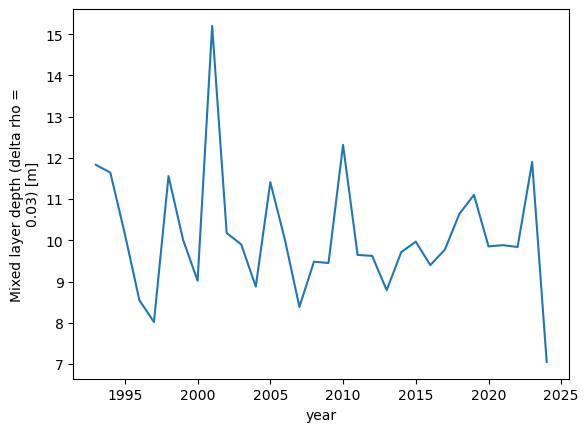

In [13]:
# take a look
ds_mean.plot()

In [14]:
# create pandas dataframe
ds_df = ds_mean.to_dataframe()
ds_df

,MLD_003
year,
1993,11.830518
1994,11.643274
1995,10.150390
1996,8.544428
1997,8.017573
1998,11.557767
1999,10.015160
2000,9.018702
2001,15.199876


In [16]:
# rename column with life stage
ds_df.rename(columns = {"MLD_003":"MLD_003_"+suffix}, inplace=True)
ds_df

,MLD_003_asdf
year,
1993,11.830518
1994,11.643274
1995,10.150390
1996,8.544428
1997,8.017573
1998,11.557767
1999,10.015160
2000,9.018702
2001,15.199876


In [17]:
# save result
ds_df.to_csv("../../Data/MOM6/output.csv")

Caveats about this output

* This was made with regridded output, and it would be more accurate to work with the raw than the regridded output. I went with regridded because it was convenient to have latitude as an index to select, but I could instead use the raw data and use latitude as a variable to mask.
* This may be too slow once moving to daily data, such as trying to calculate degree days whenever daily temperature at depth is available. This script isn't built for that.
* It would be great to meet with someone more proficient in xarray to see if there are ways to speed things up. It would also be fun to try something cloud-based and try dask, though that may be overkill for something as small as this.

In [56]:
# pass in a dataset to print the # and % records that are not np.nan
# assumes you have already imported numpy as np
def print_non_nans(dataset, var_name):
    numerator = np.isfinite(dataset[var_name].data).sum()
    denominator = dataset[var_name].size
    percent = numerator / denominator * 100
    print(f'{numerator} records are not np.nan')
    print(f'{percent:.{2}f}% records')
    return None

# for example...
print_non_nans(ds_selected, 'MLD_003')